# A simple DNN model built in Keras.

Let's start off with the Python imports that we need.

In [1]:
import os, json, math
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [2]:
# These are parameters that we will configure so that we can schedule this notebook
DATADIR = '../data'
NBUCKETS = 10  # for feature crossing
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # remember the training dataset repeats, so this will wrap around
NUM_EVALS = 5  # evaluate this many times
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but no so much that it slows down

## Locating the CSV files

We will start with the CSV files that we wrote out in the [first notebook](../01_explore/taxifare.iypnb) of this sequence. Just so you don't have to run the notebook, we saved a copy in ../data

In [3]:
if DATADIR[:5] == 'gs://':
    !gsutil ls $DATADIR/*.csv
else:
    !ls -l $DATADIR/*.csv

-rw-r--r-- 1 jupyter jupyter 126266 Jun  3 15:48 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 593612 Jun  3 15:48 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 126833 Jun  3 15:48 ../data/taxi-valid.csv


## Use tf.data to read the CSV files

We wrote these cells in the [third notebook](../03_tfdata/input_pipeline.ipynb) of this sequence.

In [4]:
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

In [5]:
def features_and_labels(row_data):
    for unwanted_col in ['key']:  # keep the pickup_datetime!
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    pattern = '{}/{}'.format(DATADIR, pattern)
    dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
               .map(features_and_labels) # features, label
               .cache())
    if mode == tf.estimator.ModeKeys.TRAIN:
        print("Repeating training dataset indefinitely")
        dataset = dataset.shuffle(1000).repeat()
    dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
    return dataset

In [6]:
import datetime
# Python 3.5 doesn't handle timezones of the form 00:00, only 0000
ts = datetime.datetime.strptime('2010-02-08 09:17:00+00:00'.replace(':',''), "%Y-%m-%d %H%M%S%z")
print(ts.weekday())
DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
print(DAYS[ts.weekday()])

0
Sun


In [7]:
## Add transformations
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff*londiff + latdiff*latdiff)

DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
def get_dayofweek(s):
    # Python 3.5 doesn't handle timezones of the form 00:00, only 0000
    ts = datetime.datetime.strptime(s.replace(':', ''), "%Y-%m-%d %H%M%S%z")
    return DAYS[ts.weekday()]

def dayofweek(ts_in):
    return tf.map_fn(
        lambda s: tf.py_function(get_dayofweek, inp=[s], Tout=tf.string),
        ts_in
    )

def transform(inputs, NUMERIC_COLS, STRING_COLS):
    transformed = inputs.copy()
    print("BEFORE TRANSFORMATION")
    print("INPUTS:", inputs.keys())
    
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
           for colname in NUMERIC_COLS
    }
    
    # scale the lat, lon values to be in 0, 1
    for lon_col in ['pickup_longitude', 'dropoff_longitude']:  # in range -70 to -78
        transformed[lon_col] = tf.keras.layers.Lambda(
            lambda x: (x+78)/8.0, 
            name='scale_{}'.format(lon_col)
        )(inputs[lon_col])
    for lat_col in ['pickup_latitude', 'dropoff_latitude']: # in range 37 to 45
        transformed[lat_col] = tf.keras.layers.Lambda(
            lambda x: (x-37)/8.0, 
            name='scale_{}'.format(lat_col)
        )(inputs[lat_col])

    # add Euclidean distance. Doesn't have to be accurate calculation because NN will calibrate it
    transformed['euclidean'] = tf.keras.layers.Lambda(euclidean, name='euclidean')([
        inputs['pickup_longitude'],
        inputs['pickup_latitude'],
        inputs['dropoff_longitude'],
        inputs['dropoff_latitude']
    ])
    feature_columns['euclidean'] = tf.feature_column.numeric_column('euclidean')
    
    # hour of day from timestamp of form '2010-02-08 09:17:00+00:00'
    transformed['hourofday'] = tf.keras.layers.Lambda(
        lambda x: tf.strings.to_number(tf.strings.substr(x, 11, 2), out_type=tf.dtypes.int32),
        name='hourofday',
        output_shape=()
    )(inputs['pickup_datetime'])
    feature_columns['hourofday'] = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_identity('hourofday', num_buckets=24))


    # day of week is hard because there is no TensorFlow function for date handling
    transformed['dayofweek'] = tf.keras.layers.Lambda(
        lambda x: tf.strings.substr(x, 0, 4), #dayofweek(x),
        name='dayofweek',
        output_shape=()
    )(inputs['pickup_datetime'])
    feature_columns['dayofweek'] = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
          'dayofweek', vocabulary_list = DAYS))
    
    # featurecross lat, lon into nxn buckets, then embed
    nbuckets = NBUCKETS
    latbuckets = np.linspace(0, 1, nbuckets).tolist()
    lonbuckets = np.linspace(0, 1, nbuckets).tolist()
    b_plat = tf.feature_column.bucketized_column(feature_columns['pickup_latitude'], latbuckets)
    b_dlat = tf.feature_column.bucketized_column(feature_columns['dropoff_latitude'], latbuckets)
    b_plon = tf.feature_column.bucketized_column(feature_columns['pickup_longitude'], lonbuckets)
    b_dlon = tf.feature_column.bucketized_column(feature_columns['dropoff_longitude'], lonbuckets)
    ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
    dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
    pd_pair = tf.feature_column.crossed_column([ploc, dloc], nbuckets ** 4 )
    feature_columns['pickup_and_dropoff'] = tf.feature_column.embedding_column(pd_pair, 100)

    print("AFTER TRANSFORMATION")
    print("TRANSFORMED:", transformed.keys())
    print("FEATURES", feature_columns.keys())   
    return transformed, feature_columns

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    # input layer is all float except for pickup_datetime which is a string
    STRING_COLS = ['pickup_datetime']
    NUMERIC_COLS = set(CSV_COLUMNS) - set([LABEL_COLUMN, 'key']) - set(STRING_COLS)
    print(STRING_COLS)
    print(NUMERIC_COLS)
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in NUMERIC_COLS
    }
    inputs.update({
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string')
           for colname in STRING_COLS
    })
    
    # transforms
    transformed, feature_columns = transform(inputs, NUMERIC_COLS, STRING_COLS)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(transformed)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu')(h1)
    # final output would normally have a linear activation because this is regression
    # However, we know something about the taxi problem (fares are +ve and tend to be below $60).
    # Use that here. (You can verify by running this query):
    # SELECT APPROX_QUANTILES(fare_amount, 100) FROM serverlessml.cleaned_training_data
    fare_thresh = lambda x: 60 * tf.keras.activations.relu(x)
    output = tf.keras.layers.Dense(1, activation=fare_thresh)(h2)
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

model = build_dnn_model()
print(model.summary())

W0604 02:44:03.501463 140388305549056 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:3048: CrossedColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0604 02:44:03.565639 140388305549056 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/lookup_ops.py:1347: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0604 02:44:03.574861 140388305549056 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:4307: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be 

['pickup_datetime']
{'pickup_latitude', 'pickup_longitude', 'dropoff_longitude', 'passenger_count', 'dropoff_latitude'}
BEFORE TRANSFORMATION
INPUTS: dict_keys(['pickup_latitude', 'passenger_count', 'dropoff_longitude', 'pickup_longitude', 'dropoff_latitude', 'pickup_datetime'])
AFTER TRANSFORMATION
TRANSFORMED: dict_keys(['pickup_latitude', 'passenger_count', 'dayofweek', 'dropoff_longitude', 'hourofday', 'pickup_longitude', 'dropoff_latitude', 'pickup_datetime', 'euclidean'])
FEATURES dict_keys(['pickup_latitude', 'pickup_and_dropoff', 'passenger_count', 'dayofweek', 'dropoff_longitude', 'hourofday', 'pickup_longitude', 'dropoff_latitude', 'euclidean'])


W0604 02:44:03.815928 140388305549056 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:4362: IdentityCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pickup_datetime (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
dropoff_latitude (InputLayer)   [(None,)]            0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None,)]            0                                            
__________________________________________________________________________________________________
pickup_longitude (InputLayer)   [(None,)]            0                                            
______________________________________________________________________________________________

## Train model

To train the model, call model.fit()

In [8]:
trainds = load_dataset('taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Repeating training dataset indefinitely
Epoch 1/5
312/312 [==============================] - 14s 45ms/step - loss: 112.2151 - rmse: 9.9083 - mse: 112.2152 - val_loss: 61.2252 - val_rmse: 7.8201 - val_mse: 61.2253
Epoch 2/5
312/312 [==============================] - 14s 43ms/step - loss: 59.2955 - rmse: 6.8098 - mse: 59.2955 - val_loss: 24.3317 - val_rmse: 4.9267 - val_mse: 24.3317
Epoch 3/5
312/312 [==============================] - 13s 43ms/step - loss: 29.8566 - rmse: 4.6614 - mse: 29.8566 - val_loss: 15.9867 - val_rmse: 3.9912 - val_mse: 15.9867
Epoch 4/5
312/312 [==============================] - 14s 43ms/step - loss: 30.5709 - rmse: 4.6829 - mse: 30.5709 - val_loss: 18.3488 - val_rmse: 4.2772 - val_mse: 18.3488
Epoch 5/5
312/312 [==============================] - 14s 43ms/step - loss: 29.0136 - rmse: 4.5504 - mse: 29.0136 - val_loss: 15.6492 - val_rmse: 3.9474 - val_mse: 15.6492


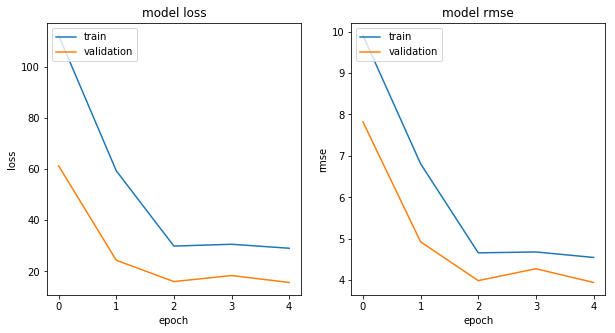

In [9]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Evaluate over full validation dataset

Let's evaluate over the full validation dataset (provided the validation dataset is large enough).

In [16]:
evalds = load_dataset('../data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(500) # 500 steps would be 500k samples
model.evaluate(evalds)

Going through dataset only once
    500/Unknown - 20s 39ms/step - loss: 15.5960 - rmse: 3.9421 - mse: 15.5960

[15.596032260894775, 3.9421325, 15.596039]

Yippee! We are now at under 4 dollars RMSE!

## Predict with model

This is how you'd predict with this model, but the string input doesn't work at present.

In [ ]:
# This doesn't work yet.
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'pickup_datetime': tf.convert_to_tensor(['2010-02-08 09:17:00+00:00'], dtype=tf.string),
})

Also, this is not realistic, because we can't expect client code to have a model object in memory. We'll have to export our model to a file, and expect client code to instantiate the model from that exported file.

## Export model

Let's export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

In [ ]:
# This doesn't work yet.
tf.keras.experimental.export_saved_model(model, export_dir)

# Recreate the exact same model
new_model = keras.experimental.load_from_saved_model(export_dir)

# try predicting with this model
new_model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),  
    'pickup_datetime': tf.convert_to_tensor(['2010-02-08 09:17:00+00:00'], dtype=tf.string),
})

In this notebook, we have looked at how to implement a custom Keras model using feature columns.

Copyright 2019 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.